In [1]:
import os,sys
sys.path.append(os.path.abspath(".."))

In [2]:
from core.modeling.base import BaseModel,Config
from core.modeling.dlrm import DLRMParams
import torch
import numpy as np
import pandas as pd
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from core.data import MovieLens
from core.utils import seed_all 
import seaborn as sns
import pathlib,json
sns.set_theme(style="darkgrid")
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
seed = 0
seed_all(seed)
new_model = False

In [3]:
filename = "dlrm.pt"
movie_lens = MovieLens.get_instance()

MovieLens has been initialized


In [4]:
num_cols = movie_lens.user_num_cols + movie_lens.movie_num_cols
cat_cols = movie_lens.user_cat_cols + movie_lens.movie_cat_cols
users_nunique = movie_lens.users[movie_lens.user_cat_cols].nunique().tolist()
movies_nunique = movie_lens.movies[movie_lens.movie_cat_cols].nunique().tolist()

# users and movies ids start from 1 not 0
movies_nunique[movie_lens.movie_cat_cols.index("movie")] += 1
users_nunique[movie_lens.user_cat_cols.index("user")] += 1

nunique = users_nunique + movies_nunique

In [5]:
ratings = movie_lens.ratings
ratings[cat_cols] = ratings[cat_cols].astype(np.int32)
ratings[num_cols] = ratings[num_cols].astype(np.float32)
ratings["rating"] = ratings["rating"].astype(np.float32)

In [6]:
class DS(torch.utils.data.Dataset):
    def __init__(
        self,
        num: pd.DataFrame,
        cat: pd.DataFrame,
        y: pd.DataFrame,
    ) -> None:
        super().__init__()
        self.num = num
        self.cat = cat
        self.y = y

    def __len__(self):
        l = self.num.shape[0]
        return l

    def __getitem__(self, index):
        num = self.num[index]
        cat = self.cat[index]
        y = self.y[index]
        # X,y
        return dict(num=num, cat=cat,y=y)

batch_size = 64*20
all_ds = DS(
    ratings[num_cols].values,
    ratings[cat_cols].values,
    ratings.rating.values,
)
train_ds, valid_ds, test_ds = torch.utils.data.random_split(all_ds,[.8, .1, .1])
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,shuffle=True)
_d=next(iter(train_dl))
_d["num"].dtype, _d["cat"].dtype, _d["y"].dtype

(torch.float32, torch.int32, torch.float32)

In [7]:
if not new_model and pathlib.Path(filename).exists():
    model,optimizer,training_result = BaseModel.load(
        filename,
    )
else:
    model = BaseModel.init_model(
        Config(
            model_name="DLRM",
            lr=.001,
            n_users=movie_lens.n_users,
            n_movies=movie_lens.n_movies,
            params=DLRMParams(
                bot_layers=[len(num_cols), 32*2],
                embds=[(n, 32*2) for n in nunique],
                top_layers=[32*2],
                bot_p=.2,
                top_p=.2,
            ),
        )
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), model.config.lr, weight_decay=0.01)
    training_result = None
# model
model.numel()*4/(1024**2)
# params.to_dict()

4.712646484375

In [8]:
movie_lens.ratings.movie_year_bin.unique()

array([6, 4, 5, 3, 2, 1, 0])

In [9]:
cat_cols[21]

'movie_year_bin'

In [11]:
epochs = 1
patience = 5
training_result = model.fit(
    optimizer,
    train_dl,   
    loss_fn=F.mse_loss,
    metric=root_mean_squared_error,
    epochs=epochs,
    val_ld=valid_dl,
    patience=patience,
    last_training_result=training_result
)

Epoch:  1, loss : 7.5257, val_loss: 7.7288: 100%|██████████| 522/522 [00:22<00:00, 23.14it/s]


Model saved.


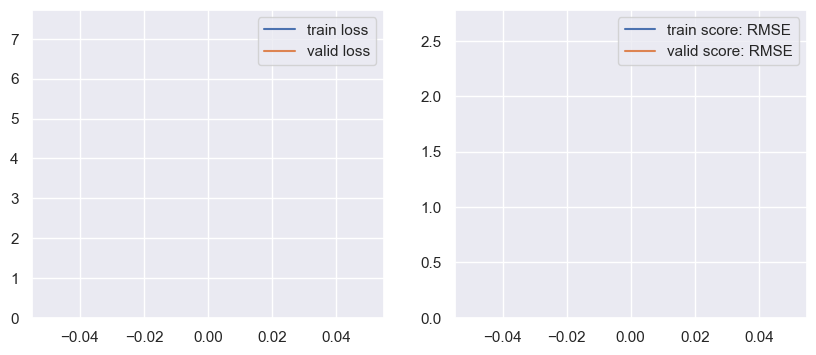

In [12]:
model.save(
    filename,
    optimizer=optimizer,
    last_training_result=training_result,
)
training_result.plot(score_name="RMSE")

In [13]:
test = test_ds[:None]
userIds = test["cat"][:, cat_cols.index("user")]
movieIds = test["cat"][:, cat_cols.index("movie")]
pred = model.recommend_for_users(
    users=userIds,
    movies=movieIds,
    **test,
    sort=False,
    wrap=False,
)
test = pd.DataFrame(dict(pred=pred,rating=test["y"],user=userIds,movie=movieIds))
test["rating"] =test["rating"] * 5 
test["error"] = test.rating - test.pred

print(f"True: mean {test.rating.mean():.3}, std {test.rating.std():.3}")
print(f"Pred: mean {test.pred.mean():.3}, std {test.pred.std():.3}")
print(f"RSME: {root_mean_squared_error(test.rating,test.pred)}")
test[["user", "movie", "rating", "pred", "error"]].head()

True: mean 17.8, std 5.3
Pred: mean 5.0, std 0.0
RSME: 13.887410165704466


,user,movie,rating,pred,error
0,1806,10204,17.5,5.0,12.5
1,4902,1826,20.0,5.0,15.0
2,2279,157,20.0,5.0,15.0
3,4391,9246,22.5,5.0,17.5
4,5940,7457,17.5,5.0,12.5


In [14]:
test.rating.unique()

array([17.5, 20. , 22.5, 15. , 25. , 10. , 12.5,  7.5,  2.5,  5. ],
      dtype=float32)

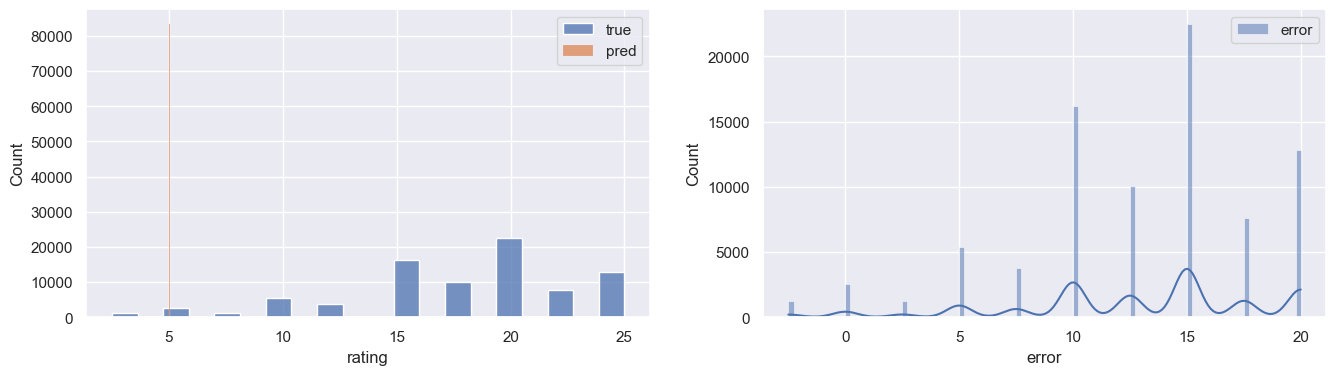

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(test.error, fill=True, label="error", ax=ax2, kde=True)

sns.histplot(test.rating, fill=True, label="true", ax=ax1, bins=20, kde=False)
sns.histplot(test.pred, fill=True, label="pred", ax=ax1, bins=20, kde=False)
ax1.legend()
ax2.legend()

In [16]:
model.recommend_for_users(**model.prepare(
    3,
    movieIds=[55, 300],
), sort=True)

[Recommendation(userId=3, movieId=55, predicted_rating=5.0),
 Recommendation(userId=3, movieId=300, predicted_rating=5.0)]